# Visualization based on Philipp Arndt's tutroial

In [1]:
%matplotlib widget
import os
import ee
import geemap
import requests
import numpy as np
import matplotlib.pylab as plt
from datetime import datetime
from datetime import timedelta
import rasterio as rio
from rasterio import plot
from rasterio import warp
import pandas as pd


from oa import dataCollector

In [2]:
try:
    ee.Initialize()
except: 
    ee.Authenticate()
    ee.Initialize()

In [3]:
PIG_20210127_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2021-01-27&minx=-101.05618280606095&miny=-75.07153639057141&maxx=-100.19763809126549&maxy=-74.74493366712844&trackId=523&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20210127_gtx = 'gt3r'

PIG_20201007_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-10-07&minx=-101.06993207685464&miny=-75.06319452393107&maxx=-100.2946192252&maxy=-74.74165227279721&trackId=210&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20201007_gtx = 'gt2r'

PIG_20201126_url = 'http://openaltimetry.org/data/api/icesat2/atl08?date=2020-11-26&minx=-101.14052925449913&miny=-75.06448446439796&maxx=-99.96378551049133&maxy=-74.71181440450334&trackId=965&beamName=gt3r&beamName=gt3l&beamName=gt2r&beamName=gt2l&beamName=gt1r&beamName=gt1l&outputFormat=json'
PIG_20201126_gtx ='gt13'

In [4]:
def plot_from_oa_url(url,gtx,title='ICESat-2 Data',plot_atl07=True,plot_atl08=True):
    mydata = dataCollector(oaurl=url,beam=gtx)
    mydata.requestData()
    myplot = mydata.plotData(title=title,plot_atl07=plot_atl07,plot_atl08=plot_atl08)
    return (myplot, mydata)

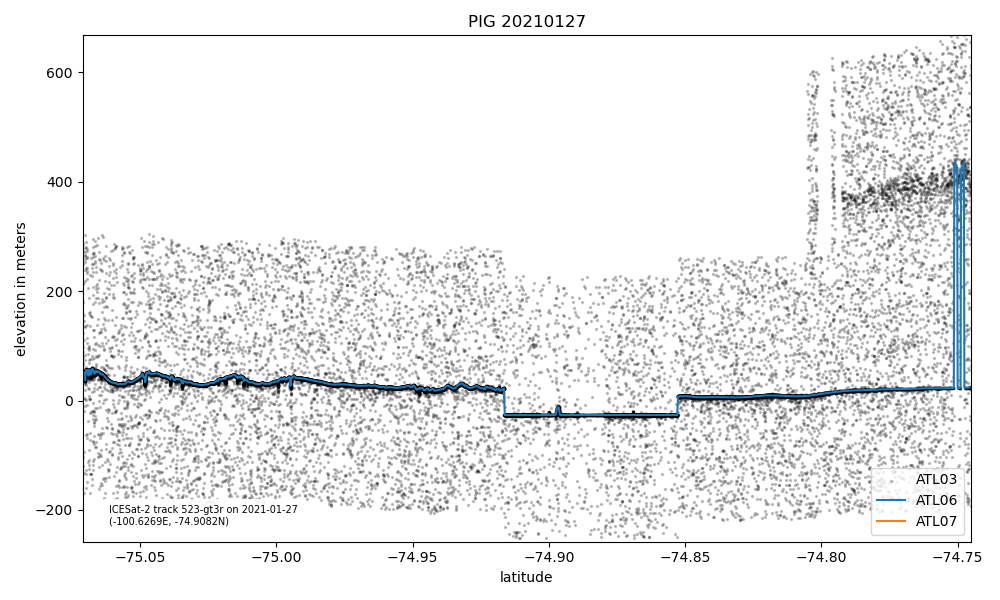

In [5]:
PIG_20210127_fig,PIG_20210127_data=plot_from_oa_url(PIG_20210127_url,PIG_20210127_gtx,title='PIG 20210127',plot_atl07=True,plot_atl08=False)

In [6]:
figfile = 'PIG_20210127_fig.png'
PIG_20210127_fig.savefig(figfile, dpi=300)

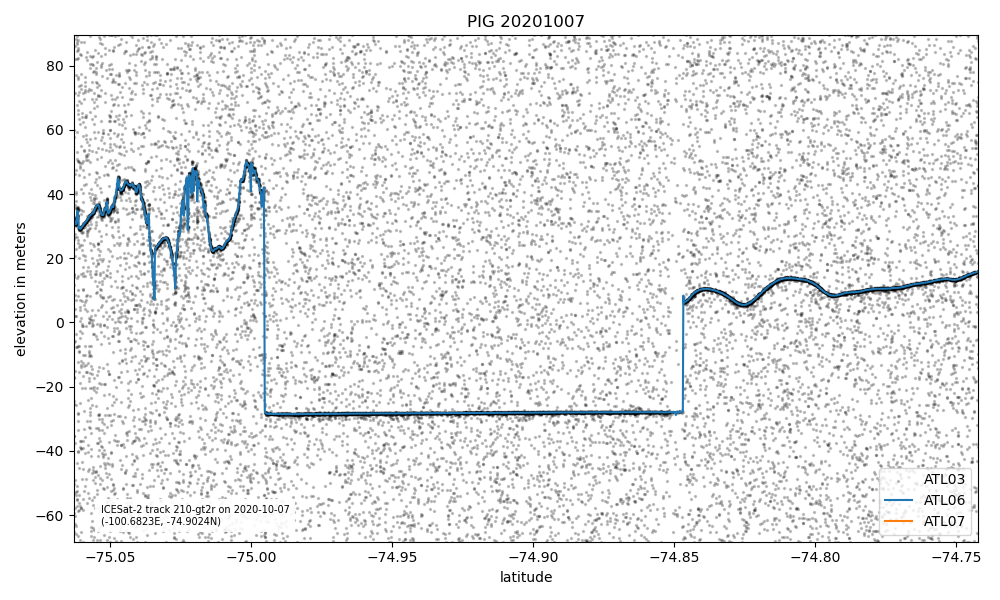

In [7]:
PIG_20201007_fig,PIG_20201007_data=plot_from_oa_url(PIG_20201007_url,PIG_20201007_gtx,title='PIG 20201007',plot_atl07=True,plot_atl08=False)

In [8]:
figfile = 'PIG_20201007_fig.png'
PIG_20201007_fig.savefig(figfile, dpi=300)

In [9]:
PIG_20201126_fig,PIG_20201126_data=plot_from_oa_url(PIG_20201126_url,PIG_20201126_gtx,title='PIG 20201126',plot_atl07=True,plot_atl08=False)

JSONDecodeError: [Errno Expecting value] <!doctype html><html lang="en"><head><title>HTTP Status 404 – Not Found</title><style type="text/css">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-color:#525D76;} h1 {font-size:22px;} h2 {font-size:16px;} h3 {font-size:14px;} p {font-size:12px;} a {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 404 – Not Found</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Not Found</p><p><b>Description</b> The origin server did not find a current representation for the target resource or is not willing to disclose that one exists.</p><hr class="line" /><h3>Apache Tomcat/8.5.63</h3></body></html>: 0

In [ ]:
figfile = 'PIG_20201126_fig.png'
PIG_20201126_fig.savefig(figfile, dpi=300)

## Now let's see where this IS-2 track is located

In [10]:
Map = geemap.Map()
Map


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [11]:
lat1, lat2 = PIG_20210127_data.atl08.lat[0], PIG_20210127_data.atl08.lat.iloc[-1]
lon1, lon2 = PIG_20210127_data.atl08.lon[0], PIG_20210127_data.atl08.lon.iloc[-1]
center_lon = (lon1 + lon2) / 2
center_lat = (lat1 + lat2) / 2
Map.setCenter(center_lon, center_lat, zoom=8);
Map.add_basemap('SATELLITE')

In [12]:
def is2_featurecollection(data):
    ground_track_coordinates = list(zip(data.atl08.lon, data.atl08.lat))
    ground_track_projection = 'EPSG:4326' 
    gtx_feature = ee.FeatureCollection(ee.Geometry.LineString(coords=ground_track_coordinates, 
                                      proj=ground_track_projection, 
                                      geodesic=True))
    return gtx_feature


PIG_20210127_feature = is2_featurecollection(PIG_20210127_data)
PIG_20201007_feature = is2_featurecollection(PIG_20201007_data)
# PIG_20201126_feature = is2_featurecollection(PIG_20201126_data)
    

In [13]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    
    #Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask).divide(10000)


def getMatchingS2Image(data,center_lon,center_lat):
    s2 = ee.ImageCollection('COPERNICUS/S2_SR')
    POI = ee.Geometry.Point(center_lon, center_lat)
    s2 = s2.filterBounds(POI)
    
    days_buffer_imagery = 30

    dateformat = '%Y-%m-%d'
    datetime_requested = datetime.strptime(data.date, dateformat)
    search_start = (datetime_requested - timedelta(days=days_buffer_imagery)).strftime(dateformat)
    search_end = (datetime_requested + timedelta(days=days_buffer_imagery)).strftime(dateformat)

    s2 = s2.filterDate(search_start, search_end)
    s2 = s2.filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than',40)
    s2 = s2.map(maskS2clouds)
    return s2.median()

In [14]:
PIG_20210127_s2Image = getMatchingS2Image(PIG_20210127_data,center_lon,center_lat)
PIG_20201007_s2Image = getMatchingS2Image(PIG_20201007_data,center_lon,center_lat)
# PIG_20201126_s2Image = getMatchingS2Image(PIG_20201126_data,center_lon,center_lat)

In [15]:
s2Vis = {
  'min': 0.0,
  'max': 0.3,
  'gamma': 1.4,
  'bands': ['B4', 'B3', 'B2'],
};

Map.addLayer(PIG_20210127_s2Image,s2Vis,'PIG_20210127_s2Image')
Map.addLayer(PIG_20201007_s2Image,s2Vis,'PIG_20201007_s2Image')
# Map.addLayer(PIG_20201126_s2Image,s2Vis,'PIG_20201126_s2Image')

In [16]:
Map.addLayer(PIG_20210127_feature,{'color':'red'},'PIG_20210127_feature')
Map.addLayer(PIG_20201007_feature,{'color':'orange'},'PIG_20201007_feature')
# Map.addLayer(PIG_20201126_feature,{'color':'magenta'},'PIG_20201126_feature')